# Import libraries

In [1]:
import numpy as np
import os
import random
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format='retina'
#plt.style.use('ggplot')

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


# Define auxiliary functions

In [2]:
def nice_plot(hist):
    """Prints the diagnostic plot"""
    
    # Two subplots, the axes array is 1-d
    fig, (ax1,ax2) = plt.subplots(2, sharex=True)
    
    fig.suptitle("Training and validation")

    ax1.plot(hist.history["accuracy"], label="Training accuracy")
    ax1.plot(hist.history["val_accuracy"], label="Validation accuracy")
    #ax1.set_title("Training and validation accuracy")
    ax1.set_ylabel("Accuracy")
    ax1.set_xlabel("Epochs")
    ax1.legend(loc="upper left")
    
    ax2.plot(history.history["loss"], label="Training loss")
    ax2.plot(history.history["val_loss"], label="Validation loss")
    #ax2.set_title("Training and validation loss")
    ax2.set_ylabel("Loss")
    ax2.set_xlabel("Epochs")
    ax2.legend(loc="upper left")
    
    plt.show()
    
def evaluate_model(model, dataset):
    """Prints the accuracy of the model evaluated on the given dataset"""
    test_loss, test_acc = model.evaluate(dataset)
    print(f"Accuracy: {test_acc:.3f}")
    

def print_trainability(model):
    """Show which layers are trainable and which are not"""
    for i, layer in enumerate(model.layers):
        print(f'{i:<2} {layer.name:<13} {layer.trainable}')

def unfreeze(model,n_layers):
    """Unfreeze the last n_layers of the model except for BatchNormalization layers"""
    for layer in model.layers[-n_layers:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
            
def compile_model(model,lr=1e-3,opt='Adam'):
    """Compile model according to learning rate and optimizer with CategoricalCrossentropy loss"""
    if opt == 'Adam':
        chosen_opt = keras.optimizers.Adam(learning_rate=lr)
    elif opt == 'RMSprop':
        chosen_opt = keras.optimizers.RMSprop(learning_rate=lr)
    else:
        print('No valid optimizer chosen')
        return
    model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=chosen_opt, metrics=["accuracy"])


def fit_model(model,patience=20,weights=None):
    """Fit model with EarlyStopping on validation accuracy and class weights if specified"""
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            mode='max',
            patience=patience,
            restore_best_weights=True),
    ]
    
    if weights:
        history = model.fit(train_dataset,epochs=5000,validation_data=validation_dataset,callbacks=callbacks,class_weight=weights)
    else:
        history = model.fit(train_dataset,epochs=5000,validation_data=validation_dataset,callbacks=callbacks)
    
    return history

# Global settings and seed

In [4]:
IMG_W = IMG_H = 96
BATCH_SIZE = 1
INPUT_SHAPE = (IMG_H,IMG_W,3)
DATASET_DIR = 'single_augmentation'
SEED = 42

tf.random.set_seed(SEED)

# Instantiate the dataset generators


Create two generators, one for training and one for validation.
It should be more correct to create one generator only and select `subset='training'` and `subset='validation'`, but in this way augmentation is applied to both sets. I prefer to create [two generators with the same split and the same seed.](https://stackoverflow.com/questions/71744605/keras-imagedatagenerator-validation-split-does-not-split-validation-data-as-expe)


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train generator with augmentation
train_image_gen  = ImageDataGenerator(rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      zoom_range=[0.5,1.5],
                                      brightness_range=[0.5,1.5],
                                      shear_range=0.2,
                                      vertical_flip=True,
                                      horizontal_flip=True,
                                      fill_mode='reflect',
                                      )


train_dataset = train_image_gen.flow_from_directory(directory=DATASET_DIR,
                                                    target_size=(IMG_H,IMG_W),
                                                    color_mode='rgb',
                                                    classes=None,
                                                    class_mode='categorical',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=SEED,
                                                    subset='training',
                                                    )

Found 1 images belonging to 1 classes.


In [6]:
batch = train_dataset.next()
batch[0][0].shape

(96, 96, 3)

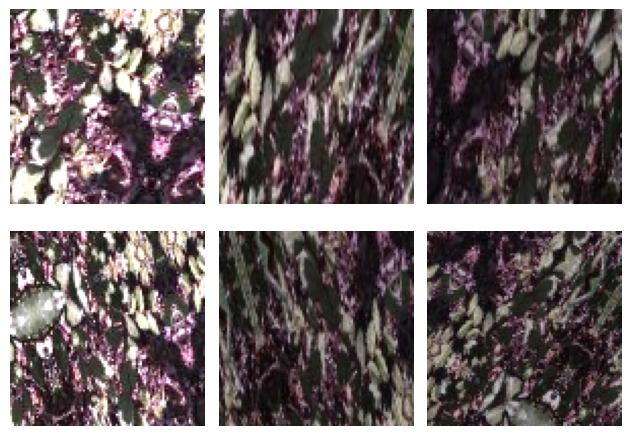

In [35]:
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    ax.axis('off') # Turn off tick labels
    batch = train_dataset.next()
    image = batch[0][0].astype('uint8')
    ax.imshow(image)

plt.tight_layout(pad=1)
plt.savefig('augmentation.pdf')
plt.show()